# cityB SVR
ver01でシンプルSVRを作成した。ここで、越智さんがしてた学習データの欠損埋めを行ってからSVRを適用してみる。  
不自然なく、欠損を埋めることで学習データの質が上がり、精度を向上することが狙う。  
変な埋め方だと逆に精度が下がるのもありうるかも？  

#### 設定

In [1]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

fatal: destination path 'geobleu' already exists and is not an empty directory.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.3-py3-none-any.whl size=5037 sha256=12e758a4a4d6cf414f626c9b312aff54f8c203fe149de6d8efd3ded55e36941c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hjauyys3/wheels/15/98/c8/330b8225e74188a134268a5ac7b536896fe9cc4650bc728bc9
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [2]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
INPUT_PATH = "../../s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz"
# INPUT_PATH = "/kaggle/input/humob2024/cityB_challengedata.csv/hiroshima_challengedata.csv"

#### データ読み込み

In [4]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head(3)

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102


#### ユーザーを絞り込み、d=60前後で訓練データと正解データに分割

In [5]:
# uidが20000~21999のデータを検証に利用
df_city_b_valid = (
    df_city_b
    .loc[df_city_b["uid"].between(20000, 21999)]
    # .loc[df_city_b["uid"].between(20000, 20010)]

)
df_city_b_valid.head(3)

,uid,d,t,x,y
20253615,20000,0,0,79,89
20253616,20000,0,2,79,89
20253617,20000,0,5,79,89


In [6]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] < 60]
)

df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] >= 60]
)

In [7]:
def get_full_df(df, d_range, t_range):
    """
    input: uid, d, t, x, yのdf
    output: 全uidでd×tを揃えたdfを作成。x, yが欠損値の場合はnull。
    """
    # 全てのd, tの範囲のデータフレームを作成
    full_range_d = pd.DataFrame({'d': range(0, d_range)})
    full_range_t = pd.DataFrame({'t': range(0, t_range)})

    # uidのユニークな値を取得し、クロス結合を行う
    full_range_uid = pd.DataFrame({'uid': df['uid'].unique()})

    # クロス結合を行う（全てのuid, d, tの組み合わせ）
    full_range = (full_range_uid.assign(key=1)
                  .merge(full_range_d.assign(key=1), on='key')
                  .merge(full_range_t.assign(key=1), on='key')
                  .drop('key', axis=1)
                 )

    # x, yの値を付与し、欠損値はnullとする
    df_train_full = (full_range
                     .merge(df, on=['uid', 'd', 't'], how='left')
                     .sort_values(by=['uid', 'd', 't'])
                    )

    return df_train_full

In [8]:
def interpolate_missing_values(df,N):
    """
    input: uid, d, t, x, yのdf、uidにつきd×tは60×48、x, y欠損値はnull
    output: 3時間未満の連続するx, y欠損を直近の前後のx, y値を用いて線形補完したdf
    """
    df_fill = df.fillna(-1).copy()  # 欠損値を一時的に -1 に変換
    skip_list = []
    interpolate_num = 0
    
    for i in range(len(df_fill)):
#     for i in range(20):
        prev_valid = None
        next_valid = None
        time_diff = None
        
        # skip_listのインデックスは飛ばす
        if i in skip_list:
            continue
        
        # x, yが欠損の場合
        if df_fill.loc[i, "x"] == -1 and df_fill.loc[i, "y"] == -1:
            # 前の有効なデータを探す
            if prev_valid is None and i != 0:
                if df_fill.loc[i - 1, "x"] != -1:
                    prev_valid = df_fill.loc[i - 1]  # 前のデータが有効な場合
            
            # 次の有効なデータを探す
            if next_valid is None:
                for j in range(i + 1, len(df)):
                    if df_fill.loc[j, "x"] != -1 and df_fill.loc[j, "y"] != -1:
                        next_valid = df_fill.loc[j]
                        break

            # 前後の有効データが見つかった場合
            if prev_valid is not None and next_valid is not None:
#                 print(i, prev_valid, next_valid)
                time_diff = int(next_valid["t"] - prev_valid["t"])
                
                # 3時間未満の欠損なら線形補完
                if (time_diff != 0) and (time_diff < N*2):
                    x_diff = next_valid["x"] - prev_valid["x"]
                    y_diff = next_valid["y"] - prev_valid["y"]
                    
                    for j in range(i, i + time_diff -1):
                        time_from_prev = df.loc[j, "t"] - prev_valid["t"]
                        # 欠損値を線形補完
                        df_fill.loc[j, "x"] = prev_valid["x"] + (x_diff / time_diff) * time_from_prev
                        df_fill.loc[j, "y"] = prev_valid["y"] + (y_diff / time_diff) * time_from_prev
                    
                    # 補完済みのインデックスをリストに追加
                    skip_list = [j for j in range(i, i + time_diff - 1)]
                    interpolate_num += len(skip_list)
#                     print(skip_list)
#                     print(df_fill.iloc[i-1:i+time_diff+3,:])
                    
#                 else:
#                     print(f"Skipping interpolation for index {i}.")
    print(f"補完数：{interpolate_num}")
    # 欠損値が補完されたdfを返す
    df_fill = df_fill[df_fill["x"]!=-1]
    df_fill["x"] =df_fill["x"].astype(int)
    df_fill["y"] =df_fill["y"].astype(int)

    
    return df_fill

In [9]:
## あとで学習データの補完もしてみる
df_city_b_train_full = get_full_df(df_city_b_train, d_range=60, t_range=48)
df_city_b_train_full

,uid,d,t,x,y
0,20000,0,0,79.0,89.0
1,20000,0,1,NaN,NaN
2,20000,0,2,79.0,89.0
3,20000,0,3,NaN,NaN
4,20000,0,4,NaN,NaN
...,...,...,...,...,...
5759995,21999,59,43,NaN,NaN
5759996,21999,59,44,NaN,NaN
5759997,21999,59,45,NaN,NaN
5759998,21999,59,46,NaN,NaN


In [10]:
INTEROILATE_N = 8
df_city_b_train_ip = interpolate_missing_values(df_city_b_train_full,INTEROILATE_N)

補完数：1269880


### 特徴量の作成

In [11]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [12]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [13]:
def attach_feature_day_of_week(df):
    # d = 0が2020/1/5に対応
    df["date"]  = pd.to_datetime("2020-01-05") + pd.to_timedelta(df["d"],unit="D")
    
    # 曜日 0:Mon,... 5:Sat,6:Sun
    df["dow"] = df["date"].dt.weekday
    
    return df.drop(columns = ["date"])

In [14]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [15]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [16]:
def attach_features(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df)
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 
    return df

In [17]:
# 学習データに特徴量付与
df_city_b_train_ip = attach_features(df_city_b_train_ip)
df_city_b_train_ip.head(2)

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,dow,weekdays,AM
0,20000,0,0,79,89,0.0,1.0,0.000000,1.000000,0,0,0,1,6,0,1
1,20000,0,1,79,89,0.0,1.0,0.258819,0.965926,0,0,0,1,6,0,1


### 学習

In [19]:
# ユーザーごと（uidごと）にデータを分けてモデルを作成
# 学習データがあるuidのみに絞り込む <- データが無い人はどうする？
uids = df_city_b_train_ip['uid'].unique()

# 各uidごとにモデルを作成し、結果を格納する辞書
models = {}
future_predictions = []

for uid in tqdm(uids,desc="Processing uids"):
    # 該当uidのデータを抽出
    user_data = df_city_b_train_ip[df_city_b_train_ip['uid'] == uid]
    # 学習に必要ないカラムは除去
    user_data_train = user_data.drop(columns=["uid","d","t","x","y"])

    #目的変数の設定
    y_train_x = user_data['x']
    y_train_y = user_data['y']

    # データの標準化
    scaler = StandardScaler()
    user_data_train_scaled = scaler.fit_transform(user_data_train)

    # SVR モデルの作成と学習 (xとyそれぞれのモデル)
    svr_x = SVR(kernel='rbf')
    svr_x.fit(user_data_train_scaled, y_train_x)

    svr_y = SVR(kernel='rbf')
    svr_y.fit(user_data_train_scaled, y_train_y) 

    # モデルの保存
    models[(uid, 'x')] = svr_x
    models[(uid, 'y')] = svr_y

    # 未来の予測
    # 予測期間の設定 (d=60からd=74まで)
    d_range = np.arange(60, 75)  # 60～74のd値
    time_range = np.arange(0, 48)  # t=0～47の範囲 (30分ごと)

    # d と t の組み合わせを生成
    future_dates = pd.DataFrame([(d, t) for d in d_range for t in time_range], columns=['d', 't'])
    
    # dとtだけで決まる特徴量を作成し、標準化
    future_dates_featured = attach_features(future_dates)
    future_dates_featured = future_dates_featured.drop(columns=["d","t"])
    future_df_scaled = scaler.transform(future_dates_featured)

    #学習したモデルで未来予測
    y_pred_x = svr_x.predict(future_df_scaled)
    y_pred_y = svr_y.predict(future_df_scaled)
    
    
    # 予測データを整形
    future_dates['uid'] = uid
    future_dates['x'] = y_pred_x
    future_dates['y'] = y_pred_y
    future_predictions.append(future_dates)


# uidをすべて結合
future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df["x"] = future_predictions_df["x"].round(0)
future_predictions_df["y"] = future_predictions_df["y"].round(0)



Processing uids:   0%|          | 0/2000 [00:00<?, ?it/s]

Processing uids: 100%|██████████| 2000/2000 [03:50<00:00,  8.68it/s]


In [20]:
future_predictions_df

,d,t,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,date,dow,uid,x,y
0,60,0,-0.433884,-0.900969,0.000000,1.000000,0,0,0,1,2020-03-05,3,20000,79.0,89.0
1,60,1,-0.433884,-0.900969,0.258819,0.965926,0,0,0,1,2020-03-05,3,20000,79.0,89.0
2,60,2,-0.433884,-0.900969,0.500000,0.866025,0,0,0,1,2020-03-05,3,20000,79.0,89.0
3,60,3,-0.433884,-0.900969,0.707107,0.707107,0,0,0,1,2020-03-05,3,20000,79.0,89.0
4,60,4,-0.433884,-0.900969,0.866025,0.500000,0,0,0,1,2020-03-05,3,20000,79.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,74,43,-0.433884,-0.900969,-0.965926,0.258819,0,0,1,0,2020-03-19,3,21999,81.0,143.0
1439996,74,44,-0.433884,-0.900969,-0.866025,0.500000,0,0,0,1,2020-03-19,3,21999,84.0,142.0
1439997,74,45,-0.433884,-0.900969,-0.707107,0.707107,0,0,0,1,2020-03-19,3,21999,84.0,142.0
1439998,74,46,-0.433884,-0.900969,-0.500000,0.866025,0,0,0,1,2020-03-19,3,21999,84.0,142.0


In [21]:
### 正解データと予測データの組み合わせ
combined_data = (
    pd.merge(
        df_city_b_answer,
        future_predictions_df.rename(columns = {"x":"x_pred","y":"y_pred"}),
        on = ["uid","d","t"],
        # ここで正解データ基準で結合してよいか？正解データ自体の欠損はどうする？
        how = "left"
    )
)[["uid","d","t","x","y","x_pred","y_pred"]]


In [46]:
combined_data[combined_data["uid"] == 20354].head(50)

,uid,d,t,x,y,x_pred,y_pred
63100,20354,60,16,78,73,76.0,69.0
63101,20354,60,18,79,74,76.0,69.0
63102,20354,60,19,77,73,76.0,68.0
63103,20354,60,22,74,75,76.0,69.0
63104,20354,60,23,75,79,76.0,68.0
63105,20354,60,32,74,77,76.0,68.0
63106,20354,60,33,77,72,76.0,69.0
63107,20354,60,37,78,72,76.0,69.0
63108,20354,60,38,77,71,77.0,71.0
63109,20354,61,14,77,70,77.0,69.0


In [25]:
list_geobleu_val = []
list_dtw_val = []

for i in tqdm(range(20000, 22000),desc="Processing uids"):
    
    # 該当uidのデータを抽出
    df = (
        combined_data
        .loc[combined_data["uid"] == i]
    )

    # 予測値のリスト
    df_pred = df[["d", "t", "x_pred", "y_pred"]]
    list_pred = [tuple(row) for row in df_pred.to_records(index=False)]

    # 正解値のリスト
    df_answer = df[["d", "t", "x", "y"]]
    list_answer = [tuple(row) for row in df_answer.to_records(index=False)]

    # if (len(list_pred) > 0) and (len(list_answer) > 0) :
    #     # スコア算出
    #     geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    #     list_geobleu_val.append(geobleu_val)
        
    #     dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    #     list_dtw_val.append(dtw_val)

    # スコア算出
    geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    list_geobleu_val.append(geobleu_val)
    
    dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    list_dtw_val.append(dtw_val)


Processing uids: 100%|██████████| 2000/2000 [04:53<00:00,  6.81it/s]


In [26]:
print(f"geobleu:{np.mean(list_geobleu_val)}")
print(f"dtw:{np.mean(list_dtw_val)}")

geobleu:0.23144646201037913
dtw:24.75290723926348


(array([266., 244., 246., 238., 191., 171., 160., 121., 116.,  72.,  58.,
         44.,  34.,  16.,  13.,   3.,   3.,   0.,   0.,   4.]),
 array([1.90673321e-14, 4.89122651e-02, 9.78245302e-02, 1.46736795e-01,
        1.95649060e-01, 2.44561325e-01, 2.93473590e-01, 3.42385856e-01,
        3.91298121e-01, 4.40210386e-01, 4.89122651e-01, 5.38034916e-01,
        5.86947181e-01, 6.35859446e-01, 6.84771711e-01, 7.33683976e-01,
        7.82596241e-01, 8.31508506e-01, 8.80420771e-01, 9.29333037e-01,
        9.78245302e-01]),
 <BarContainer object of 20 artists>)

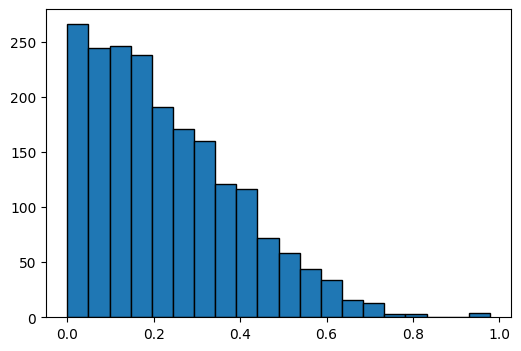

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(list_geobleu_val, bins=20, edgecolor='black')

(array([1.349e+03, 3.940e+02, 1.410e+02, 5.300e+01, 3.000e+01, 1.500e+01,
        5.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.        ,  24.10516898,  48.21033796,  72.31550694,
         96.42067592, 120.5258449 , 144.63101388, 168.73618285,
        192.84135183, 216.94652081, 241.05168979, 265.15685877,
        289.26202775, 313.36719673, 337.47236571, 361.57753469,
        385.68270367, 409.78787265, 433.89304163, 457.9982106 ,
        482.10337958]),
 <BarContainer object of 20 artists>)

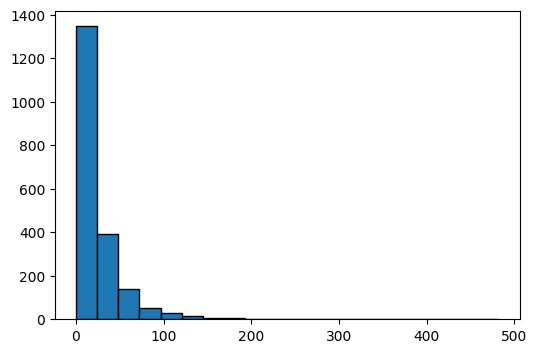

In [28]:
plt.figure(figsize=(6, 4))
plt.hist(list_dtw_val, bins=20, edgecolor='black')

## 可視化して確認

In [39]:
uid = 20308

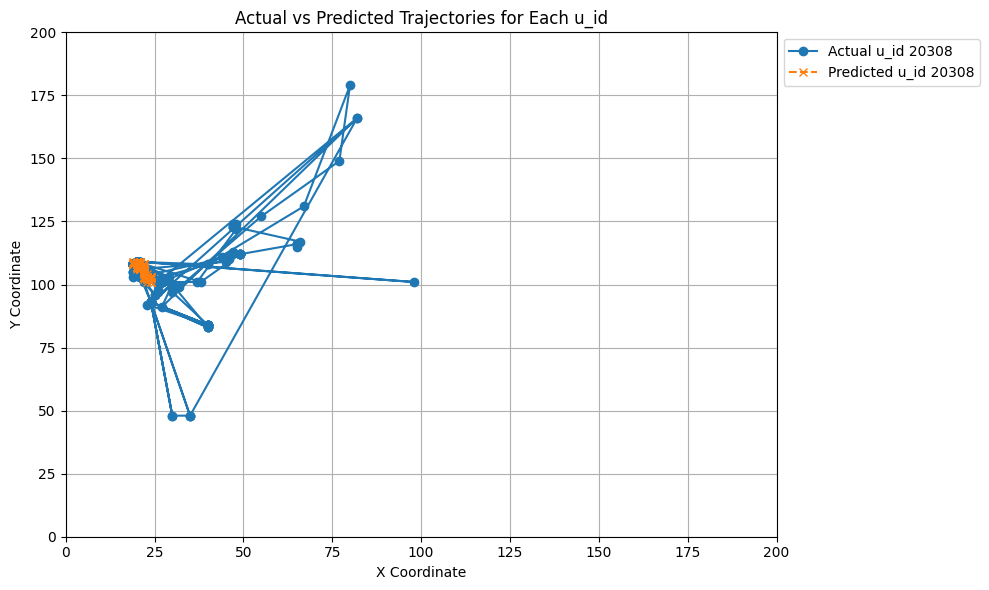

In [40]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 200)  # x軸の範囲を設定
plt.ylim(0, 200)  # y軸の範囲を設定

# プロットを表示
plt.tight_layout()
plt.show()

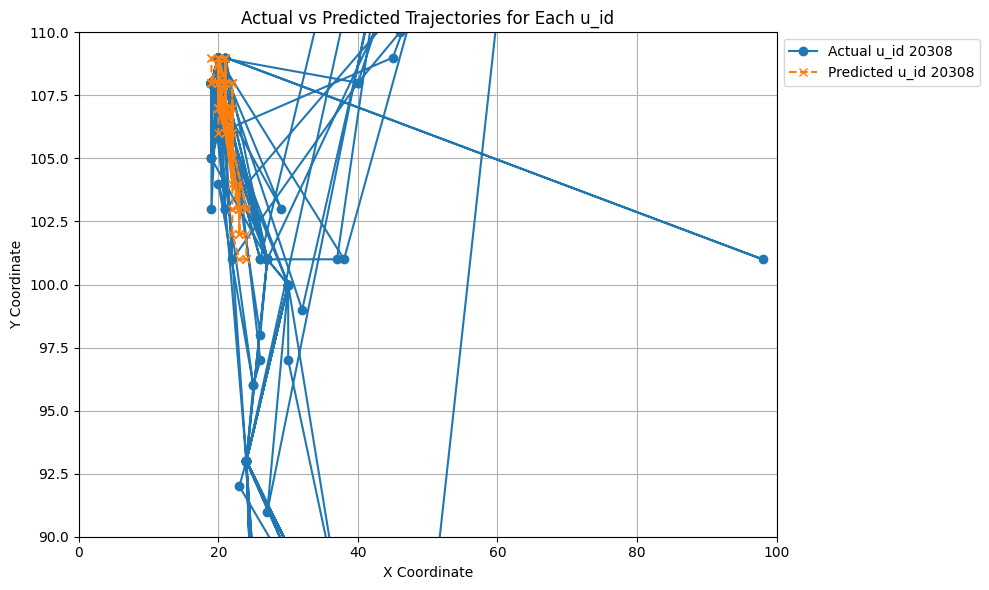

In [44]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 100)  # x軸の範囲を設定
plt.ylim(90, 110)  # y軸の範囲を設定


# プロットを表示
plt.tight_layout()
plt.show()